In [34]:
import pkg_resources

In [1]:
import os
import scanpy as sc
from os.path import join

import sys
sys.path.insert(0, '../..')

from spamosaic.framework import SpaMosaic

In [ ]:
pip install torch==2.1.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
pip install torch_geometric==2.4.0 pyg_lib==0.3.1+pt21cu121 torch_scatter==2.1.2+pt21cu121 torch_sparse==0.6.18+pt21cu121 torch_cluster==1.6.3+pt21cu121 torch_spline_conv==1.2.2+pt21cu121 -f https://data.pyg.org/whl/torch-2.1.1+cu121.html

# pip install pyg_lib==0.3.1+pt21cu121 -f https://data.pyg.org/whl/torch-2.1.1+cu121.html
# pip install torch_scatter==2.1.2+pt21cu121 -f https://data.pyg.org/whl/torch-2.1.1+cu121.html
# pip install torch_sparse==0.6.18+pt21cu121 -f https://data.pyg.org/whl/torch-2.1.1+cu121.html
# pip install torch_cluster==1.6.3+pt21cu121 -f https://data.pyg.org/whl/torch-2.1.1+cu121.html
# pip install torch_spline_conv==1.2.2+pt21cu121 -f https://data.pyg.org/whl/torch-2.1.1+cu121.html

In [2]:
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
data_dir = '/home/xuhua/xuhua_disco/gitrepo/BridgeNorm/SpaMosaic-release/data/integration/Mouse_embryo'

ad1_rna = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_rna.h5ad'))
ad1_atac = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_atac.h5ad'))
ad2_atac = sc.read_h5ad(join(data_dir, 'slice2/s2_adata_atac.h5ad'))
ad3_atac = sc.read_h5ad(join(data_dir, 'slice3/s3_adata_atac.h5ad'))
ad4_atac = sc.read_h5ad(join(data_dir, 'slice4/s4_adata_atac.h5ad'))

### preprocessing

In [4]:
ad1_rna

AnnData object with n_obs × n_vars = 2186 × 20900
    obs: 'src'
    obsm: 'spatial'
    layers: 'counts'

In [5]:
input_dict = {
    'rna':  [ad1_rna,  None,     None,     None],
    'atac': [ad1_atac, ad2_atac, ad3_atac, ad4_atac]
}

input_key = 'dimred_bc'

In [6]:
RNA_preprocess(input_dict['rna'], batch_corr=False, n_hvg=5000, batch_key='src', key=input_key)
Epigenome_preprocess(input_dict['atac'], batch_corr=True, n_peak=50000, batch_key='src', key=input_key)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


### training

In [7]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knn=10, inter_knn=10, w_g=0.8, 
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.01, n_epochs=100)

batch0: ['rna', 'atac']
batch1: ['atac']
batch2: ['atac']
batch3: ['atac']
------Calculating spatial graph...
The graph contains 21860 edges, 2186 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 21860 edges, 2186 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 21620 edges, 2162 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 22740 edges, 2274 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 22010 edges, 2201 cells.
10.0000 neighbors per cell on average.
Number of mnn pairs for rna:0
Number of mnn pairs for atac:19124
{0: (True, 2186, 2186, 1, 2, ['rna', 'atac']), 1: (False, ['atac']), 2: (False, ['atac']), 3: (False, ['atac'])}


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.21it/s]


In [8]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

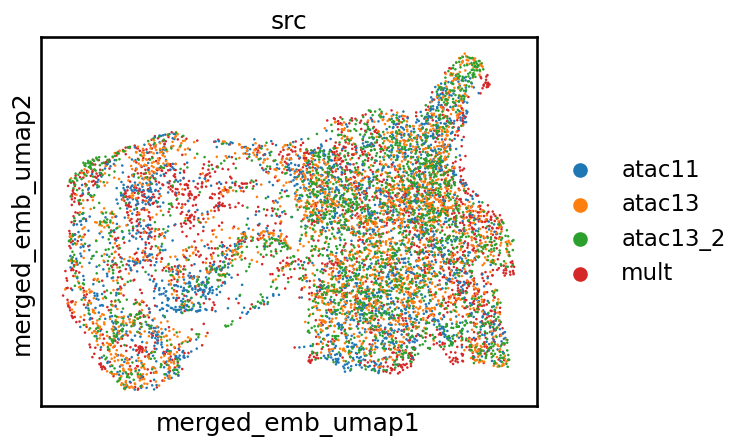

In [9]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

In [11]:
model.loss_rec[:10]

[1.0704877376556396,
 1.1351069211959839,
 1.0739481449127197,
 1.0305430889129639,
 0.9896426200866699,
 0.9288796186447144,
 0.8689331412315369,
 0.8121418952941895,
 0.7785340547561646,
 0.7519167065620422]

In [13]:
model.loss_cl[:10]

[72.45193481445312,
 61.89883041381836,
 32.97737503051758,
 23.230926513671875,
 19.641517639160156,
 16.510107040405273,
 14.199578285217285,
 12.461141586303711,
 11.529278755187988,
 10.647143363952637]

### clustering

In [14]:
utls.clustering(ad_mosaic, n_cluster=12, used_obsm='merged_emb', algo='mclust', key='mclust')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

  |======================================================================| 100%


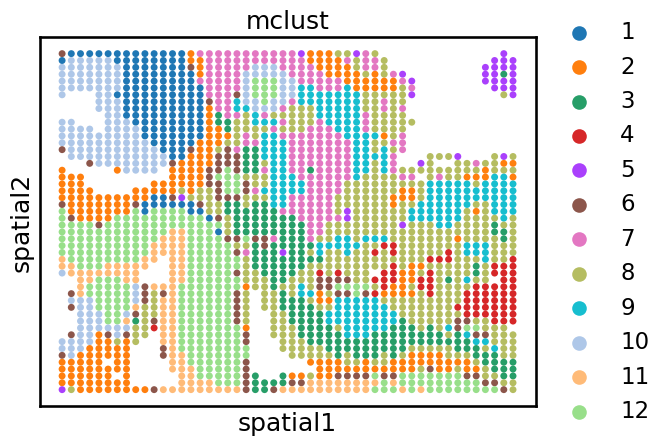

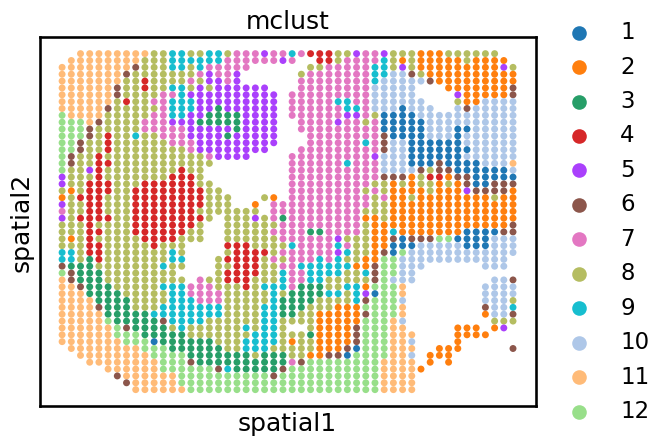

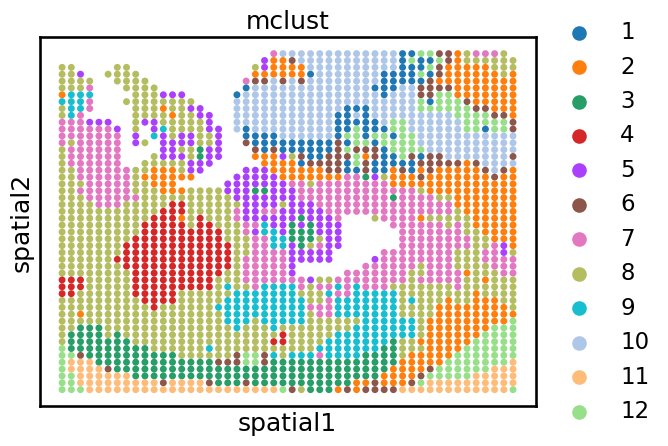

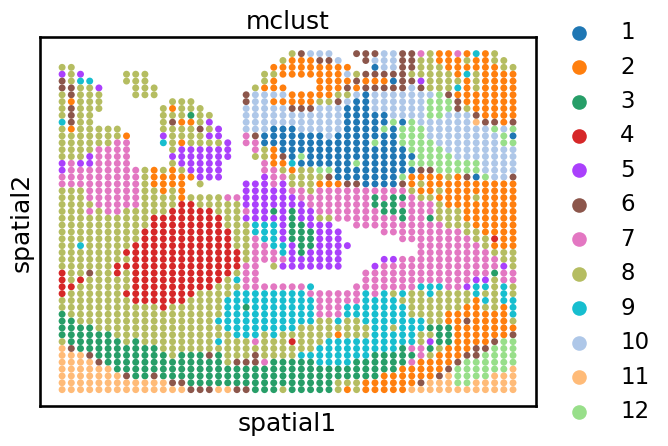

In [15]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'mclust', s=100)